In [1]:
import math
from pathlib import Path
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm

# Local modules
from modules import preprocessing

### Dataset: Importing images and annotations

In [2]:
DATASET_PATH = Path("datasets/dataset_2layers_0(25 shafts)_synthetic")

In [3]:
img_paths = list(DATASET_PATH.glob("**/*.bmp"))
ann_paths = list(DATASET_PATH.glob("**/*.txt"))

In [4]:
img_paths[0]

WindowsPath('datasets/dataset_2layers_0(25 shafts)_synthetic/image_000800.bmp')

### Viewing image

In [5]:
img = cv2.imread(str(img_paths[0]), 0)

In [6]:
img.shape

(256, 256)

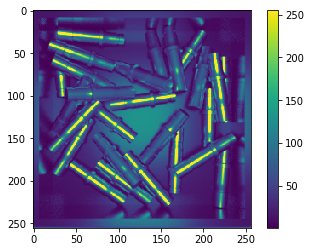

In [7]:
plt.imshow(img, cmap="viridis")
plt.colorbar()
plt.show()

### Preprocessing

In [8]:
num = 0
test_image = cv2.imread(str(img_paths[num]))
test_annot = np.loadtxt(ann_paths[num])

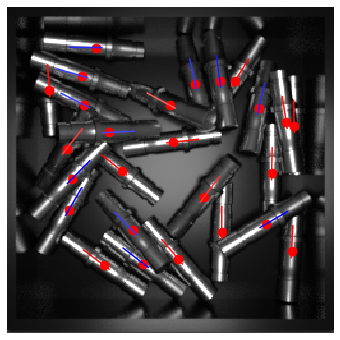

In [9]:
preprocessing.draw_annot(test_image, test_annot)

In [10]:
type(test_annot)

numpy.ndarray